In [15]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((10000,), (5000,), (55000,))

In [17]:
# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    # scale = 255. - mean # std or sqrt(var), 255 == 2**8 or 8 bit grayscale
    # return (X_train - mean)/ scale, (X_val - mean)/ scale, (X_test - mean) / scale
    return X_train - mean, X_val - mean, X_test - mean

X_train, X_val, X_test = prepro(X_train, X_val, X_test)

In [18]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        # self.mode = 'classification'
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'smooth train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        
        # Input layer
        m = dict(W=np.random.randn(D, H) / np.sqrt(D / 2.),
                 b=np.zeros((1, H)))
        #         low, high = (-1. / np.sqrt(D / 2.)), (+1. / np.sqrt(D / 2.))
        #         m = dict(W=np.random.uniform(size=(D, H), low=low, high=high),
        #                  b=np.zeros((1, H)))
        self.model.append(m)

        # Hidden layers
        m = dict(W=np.random.randn(H, H) / np.sqrt(H / 2.),
                 b=np.zeros((1, H)))
        #         low, high = (-1. / np.sqrt(H / 2.)), (+1. / np.sqrt(H / 2.))
        #         m = dict(W=np.random.uniform(size=(H, H), low=low, high=high),
        #                  b=np.zeros((1, H)))
        m_L = []
        for _ in range(L):
            m_L.append(m)
        self.model.append(m_L)
        
        # Output layer
        m = dict(W=np.random.randn(H, C) / np.sqrt(H / 2.),
                 b=np.zeros((1, C)))
        #         low, high = (-1. / np.sqrt(H / 2.)), (+1. / np.sqrt(H / 2.))
        #         m = dict(W=np.random.uniform(size=(H, C), low=low, high=high),
        #                  b=np.zeros((1, C)))
        self.model.append(m)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, h = cache

        dW = h.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        dX = dout @ W.T # Backprop

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = selu_forward(X=y)
        X = y.copy() # pass the previous output to the next layer
        caches.append((fc_cache, nl_cache)) # caches[0]
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = selu_forward(X=y)
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
            nl_caches.append(nl_cache)
        caches.append((fc_caches, nl_caches)) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
    
    def train_backward(self, dy, caches):
        grads = []

        # Input layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        
        # Hidden layer
        grad = []
        for layer in range(self.L):
            grad.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        grads.append(grad)

        # Outout layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Input layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        dy = dX.copy() # pass it to the previous layer
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = selu_backward(dout=dy, cache=nl_caches[layer])
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = selu_backward(dout=dy, cache=nl_cache)
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Momentums
        M, R = [], []

        # Input layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers momentum
        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)

        # Output layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
 
        # Learning decay
        beta1 = .9
        beta2 = .99
        smooth_train = 1.

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            #         """
            #         Single training step over minibatch: forward, loss, backprop
            #         """
            # Shuffle for each epochs/ stochasticity/ randomly choosing
            #             for idx in range(len(minibatches)):
            #             for _ in range(10):
            # Shuffle in every iteration
            # The dataset is static and non-sequentiol: no time-dependency or temporal pattern
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            smooth_train = (0.999 * smooth_train) + (0.001 * loss)
            self.losses['smooth train'].append(smooth_train)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]
                # M[0][key] = l.exp_running_avg(M[0][key], grads[0][key], beta1)
                # R[0][key] = l.exp_running_avg(R[0][key], grads[0][key]**2, beta2)
                # m_k_hat = M[0][key] / (1. - (beta1**(iter)))
                # r_k_hat = R[0][key] / (1. - (beta2**(iter)))
                # self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]
                    # M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grads[1][layer][key], beta1)
                    # R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grads[1][layer][key]**2, beta2)
                    # m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
                    # r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))
                    # self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)


            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                # M[2][key] = l.exp_running_avg(M[2][key], grads[2][key], beta1)
                # R[2][key] = l.exp_running_avg(R[2][key], grads[2][key]**2, beta2)
                # m_k_hat = M[2][key] / (1. - (beta1**(iter)))
                # r_k_hat = R[2][key] / (1. - (beta2**(iter)))
                # self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)


            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [19]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.adam(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.6073 valid loss: 2.6481, valid accuracy: 0.1144
Iter-20 train loss: 2.7863 valid loss: 2.5849, valid accuracy: 0.1204
Iter-30 train loss: 2.4829 valid loss: 2.5300, valid accuracy: 0.1286
Iter-40 train loss: 2.4650 valid loss: 2.4687, valid accuracy: 0.1354
Iter-50 train loss: 2.4562 valid loss: 2.4154, valid accuracy: 0.1452
Iter-60 train loss: 2.3232 valid loss: 2.3638, valid accuracy: 0.1564
Iter-70 train loss: 2.0872 valid loss: 2.3142, valid accuracy: 0.1652
Iter-80 train loss: 2.1284 valid loss: 2.2612, valid accuracy: 0.1762
Iter-90 train loss: 2.2015 valid loss: 2.2126, valid accuracy: 0.1896
Iter-100 train loss: 2.2306 valid loss: 2.1652, valid accuracy: 0.2022
Iter-110 train loss: 2.1185 valid loss: 2.1239, valid accuracy: 0.2140
Iter-120 train loss: 2.0098 valid loss: 2.0813, valid accuracy: 0.2280
Iter-130 train loss: 1.9960 valid loss: 2.0421, valid accuracy: 0.2436
Iter-140 train loss: 1.9394 valid loss: 2.0021, valid accuracy: 0.2610
Iter-150 train 

Iter-1170 train loss: 0.8119 valid loss: 0.8324, valid accuracy: 0.7940
Iter-1180 train loss: 0.9357 valid loss: 0.8290, valid accuracy: 0.7952
Iter-1190 train loss: 0.8385 valid loss: 0.8257, valid accuracy: 0.7958
Iter-1200 train loss: 0.7439 valid loss: 0.8221, valid accuracy: 0.7946
Iter-1210 train loss: 0.7976 valid loss: 0.8186, valid accuracy: 0.7950
Iter-1220 train loss: 0.9054 valid loss: 0.8152, valid accuracy: 0.7954
Iter-1230 train loss: 0.8145 valid loss: 0.8115, valid accuracy: 0.7968
Iter-1240 train loss: 1.0351 valid loss: 0.8082, valid accuracy: 0.7996
Iter-1250 train loss: 0.8505 valid loss: 0.8047, valid accuracy: 0.7994
Iter-1260 train loss: 0.8587 valid loss: 0.8018, valid accuracy: 0.7998
Iter-1270 train loss: 0.7799 valid loss: 0.7988, valid accuracy: 0.8008
Iter-1280 train loss: 0.8107 valid loss: 0.7960, valid accuracy: 0.8012
Iter-1290 train loss: 0.9527 valid loss: 0.7926, valid accuracy: 0.8008
Iter-1300 train loss: 0.7139 valid loss: 0.7892, valid accuracy:

Iter-2310 train loss: 0.5729 valid loss: 0.5959, valid accuracy: 0.8454
Iter-2320 train loss: 0.4991 valid loss: 0.5949, valid accuracy: 0.8468
Iter-2330 train loss: 0.6844 valid loss: 0.5936, valid accuracy: 0.8462
Iter-2340 train loss: 0.5224 valid loss: 0.5924, valid accuracy: 0.8466
Iter-2350 train loss: 0.7404 valid loss: 0.5912, valid accuracy: 0.8474
Iter-2360 train loss: 0.4724 valid loss: 0.5899, valid accuracy: 0.8476
Iter-2370 train loss: 0.7419 valid loss: 0.5888, valid accuracy: 0.8478
Iter-2380 train loss: 0.6788 valid loss: 0.5876, valid accuracy: 0.8486
Iter-2390 train loss: 0.8313 valid loss: 0.5866, valid accuracy: 0.8484
Iter-2400 train loss: 0.4749 valid loss: 0.5854, valid accuracy: 0.8490
Iter-2410 train loss: 0.5285 valid loss: 0.5842, valid accuracy: 0.8480
Iter-2420 train loss: 0.5824 valid loss: 0.5831, valid accuracy: 0.8494
Iter-2430 train loss: 0.7806 valid loss: 0.5820, valid accuracy: 0.8496
Iter-2440 train loss: 0.5002 valid loss: 0.5808, valid accuracy:

Iter-3450 train loss: 0.5933 valid loss: 0.4992, valid accuracy: 0.8672
Iter-3460 train loss: 0.9209 valid loss: 0.4987, valid accuracy: 0.8678
Iter-3470 train loss: 0.3888 valid loss: 0.4982, valid accuracy: 0.8672
Iter-3480 train loss: 0.5227 valid loss: 0.4975, valid accuracy: 0.8676
Iter-3490 train loss: 0.5533 valid loss: 0.4971, valid accuracy: 0.8684
Iter-3500 train loss: 0.2860 valid loss: 0.4965, valid accuracy: 0.8686
Iter-3510 train loss: 0.6362 valid loss: 0.4958, valid accuracy: 0.8688
Iter-3520 train loss: 0.6141 valid loss: 0.4953, valid accuracy: 0.8686
Iter-3530 train loss: 0.3891 valid loss: 0.4948, valid accuracy: 0.8690
Iter-3540 train loss: 0.5801 valid loss: 0.4943, valid accuracy: 0.8694
Iter-3550 train loss: 0.5411 valid loss: 0.4936, valid accuracy: 0.8698
Iter-3560 train loss: 0.5781 valid loss: 0.4931, valid accuracy: 0.8690
Iter-3570 train loss: 0.4227 valid loss: 0.4925, valid accuracy: 0.8696
Iter-3580 train loss: 0.5635 valid loss: 0.4919, valid accuracy:

Iter-4590 train loss: 0.5484 valid loss: 0.4461, valid accuracy: 0.8792
Iter-4600 train loss: 0.4817 valid loss: 0.4458, valid accuracy: 0.8790
Iter-4610 train loss: 0.5832 valid loss: 0.4455, valid accuracy: 0.8792
Iter-4620 train loss: 0.4654 valid loss: 0.4451, valid accuracy: 0.8784
Iter-4630 train loss: 0.4614 valid loss: 0.4446, valid accuracy: 0.8796
Iter-4640 train loss: 0.7067 valid loss: 0.4442, valid accuracy: 0.8794
Iter-4650 train loss: 0.3707 valid loss: 0.4441, valid accuracy: 0.8794
Iter-4660 train loss: 0.3053 valid loss: 0.4438, valid accuracy: 0.8792
Iter-4670 train loss: 0.3453 valid loss: 0.4436, valid accuracy: 0.8790
Iter-4680 train loss: 0.4491 valid loss: 0.4433, valid accuracy: 0.8796
Iter-4690 train loss: 0.4298 valid loss: 0.4428, valid accuracy: 0.8800
Iter-4700 train loss: 0.3987 valid loss: 0.4424, valid accuracy: 0.8798
Iter-4710 train loss: 0.4139 valid loss: 0.4420, valid accuracy: 0.8800
Iter-4720 train loss: 0.4347 valid loss: 0.4416, valid accuracy:

Iter-5730 train loss: 0.3220 valid loss: 0.4122, valid accuracy: 0.8844
Iter-5740 train loss: 0.4081 valid loss: 0.4120, valid accuracy: 0.8840
Iter-5750 train loss: 0.4421 valid loss: 0.4118, valid accuracy: 0.8846
Iter-5760 train loss: 0.4515 valid loss: 0.4115, valid accuracy: 0.8846
Iter-5770 train loss: 0.4402 valid loss: 0.4112, valid accuracy: 0.8846
Iter-5780 train loss: 0.4011 valid loss: 0.4110, valid accuracy: 0.8850
Iter-5790 train loss: 0.5483 valid loss: 0.4109, valid accuracy: 0.8852
Iter-5800 train loss: 0.4238 valid loss: 0.4106, valid accuracy: 0.8850
Iter-5810 train loss: 0.3420 valid loss: 0.4101, valid accuracy: 0.8856
Iter-5820 train loss: 0.3881 valid loss: 0.4099, valid accuracy: 0.8850
Iter-5830 train loss: 0.3729 valid loss: 0.4096, valid accuracy: 0.8856
Iter-5840 train loss: 0.4456 valid loss: 0.4093, valid accuracy: 0.8858
Iter-5850 train loss: 0.3548 valid loss: 0.4092, valid accuracy: 0.8852
Iter-5860 train loss: 0.3884 valid loss: 0.4090, valid accuracy:

Iter-6870 train loss: 0.3111 valid loss: 0.3885, valid accuracy: 0.8894
Iter-6880 train loss: 0.3106 valid loss: 0.3882, valid accuracy: 0.8900
Iter-6890 train loss: 0.4594 valid loss: 0.3880, valid accuracy: 0.8896
Iter-6900 train loss: 0.4039 valid loss: 0.3878, valid accuracy: 0.8900
Iter-6910 train loss: 0.3406 valid loss: 0.3878, valid accuracy: 0.8894
Iter-6920 train loss: 0.4725 valid loss: 0.3876, valid accuracy: 0.8894
Iter-6930 train loss: 0.5584 valid loss: 0.3874, valid accuracy: 0.8888
Iter-6940 train loss: 0.3744 valid loss: 0.3873, valid accuracy: 0.8888
Iter-6950 train loss: 0.4664 valid loss: 0.3872, valid accuracy: 0.8890
Iter-6960 train loss: 0.1519 valid loss: 0.3871, valid accuracy: 0.8890
Iter-6970 train loss: 0.3444 valid loss: 0.3869, valid accuracy: 0.8890
Iter-6980 train loss: 0.4307 valid loss: 0.3869, valid accuracy: 0.8888
Iter-6990 train loss: 0.5783 valid loss: 0.3867, valid accuracy: 0.8890
Iter-7000 train loss: 0.2574 valid loss: 0.3866, valid accuracy:

Iter-8010 train loss: 0.2321 valid loss: 0.3710, valid accuracy: 0.8934
Iter-8020 train loss: 0.4735 valid loss: 0.3709, valid accuracy: 0.8938
Iter-8030 train loss: 0.4338 valid loss: 0.3706, valid accuracy: 0.8942
Iter-8040 train loss: 0.2825 valid loss: 0.3705, valid accuracy: 0.8944
Iter-8050 train loss: 0.2689 valid loss: 0.3702, valid accuracy: 0.8940
Iter-8060 train loss: 0.3327 valid loss: 0.3701, valid accuracy: 0.8940
Iter-8070 train loss: 0.4425 valid loss: 0.3699, valid accuracy: 0.8938
Iter-8080 train loss: 0.3358 valid loss: 0.3700, valid accuracy: 0.8942
Iter-8090 train loss: 0.3032 valid loss: 0.3700, valid accuracy: 0.8940
Iter-8100 train loss: 0.4349 valid loss: 0.3698, valid accuracy: 0.8942
Iter-8110 train loss: 0.3407 valid loss: 0.3699, valid accuracy: 0.8944
Iter-8120 train loss: 0.3331 valid loss: 0.3698, valid accuracy: 0.8944
Iter-8130 train loss: 0.3090 valid loss: 0.3697, valid accuracy: 0.8944
Iter-8140 train loss: 0.3105 valid loss: 0.3696, valid accuracy:

Iter-9150 train loss: 0.4560 valid loss: 0.3569, valid accuracy: 0.8978
Iter-9160 train loss: 0.3141 valid loss: 0.3568, valid accuracy: 0.8978
Iter-9170 train loss: 0.2279 valid loss: 0.3567, valid accuracy: 0.8980
Iter-9180 train loss: 0.3092 valid loss: 0.3567, valid accuracy: 0.8978
Iter-9190 train loss: 0.3871 valid loss: 0.3565, valid accuracy: 0.8978
Iter-9200 train loss: 0.3704 valid loss: 0.3564, valid accuracy: 0.8980
Iter-9210 train loss: 0.3309 valid loss: 0.3565, valid accuracy: 0.8982
Iter-9220 train loss: 0.3352 valid loss: 0.3564, valid accuracy: 0.8988
Iter-9230 train loss: 0.7274 valid loss: 0.3564, valid accuracy: 0.8988
Iter-9240 train loss: 0.3400 valid loss: 0.3562, valid accuracy: 0.8980
Iter-9250 train loss: 0.3720 valid loss: 0.3562, valid accuracy: 0.8978
Iter-9260 train loss: 0.3344 valid loss: 0.3562, valid accuracy: 0.8974
Iter-9270 train loss: 0.3163 valid loss: 0.3561, valid accuracy: 0.8980
Iter-9280 train loss: 0.3952 valid loss: 0.3560, valid accuracy:

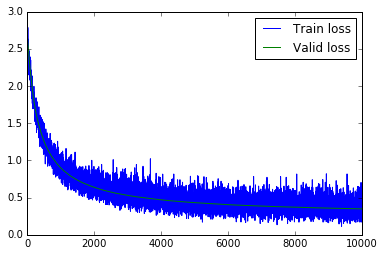

In [20]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

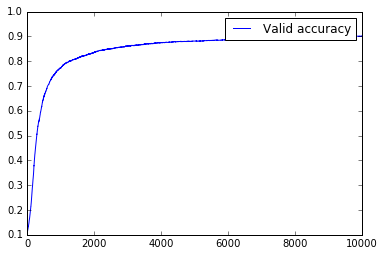

In [21]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()